# TAOS mars3D: tides

- load time series 
- compute tidal analysis
- make prediction and compare
- compute envelopes of semi-diurnal/diurnal tides
- compute harmonic analysis over entire domain

In [1]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import xarray as xr
import pandas as pd

import dask
from dask import delayed

from matplotlib import pyplot as plt
%matplotlib inline

import pytide

import taos.utils as ut
import taos.mars as ms

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(processes=4, cores=4) # std
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54067,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:46750,Total threads: 7
Dashboard: http://127.0.0.1:44577/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:58755,


---

## load data subset

- process one month at a time
- ?chunks in time should be equivalent to one month eventually?
- store

**The processing over the full dataset is now done non interactively, see station.pbs and station.py**


In [3]:
year = "2011"

files = ms.browse_files(year)

#files = files.loc["2011-11-01":] # tmp !!

print("Number of data files = {} ".format(len(files)))

#years = files.reset_index()["index"].apply(lambda t: t.year).unique()


Number of data files = 8760 


In [4]:
# select one location
f = files.iloc[0]["files"]
ds = xr.open_dataset(f)
idx = ms.get_horizontal_indices(ds)
idx

{'rho': {'nj': 102.0, 'ni': 128.0},
 'u': {'nj_u': 102.0, 'ni_u': 128.5},
 'v': {'nj_v': 101.5, 'ni_v': 128.0},
 'position': (-0.6, 49.7)}

In [32]:
def _preprocess(ds):
    ds = (ds.sel(**idx["rho"], **idx["u"], **idx["v"])
          .drop_dims(["ni_f", "nj_f"])
         )
    return ds

def combine_files(df):
    with dask.config.set(scheduler="threads"):    
        ds = xr.open_mfdataset(df["files"],
                               concat_dim="time", 
                               preprocess=_preprocess, 
                               combine="nested",
                               coords="minimal",
                               compat="override",
                              )
        return ds

combine_files_delayed = delayed(combine_files)

def process_top(files, label, freq="5D", overwrite=False):
    
    file_out = os.path.join(ms.diag_dir, "station_{}.nc".format(label))
        
    if not os.path.isfile(file_out) or overwrite:

        delayed_outputs = [combine_files_delayed(g, _preprocess) 
                           for label, g in files.groupby(pd.Grouper(freq=freq))
                          ]
        outputs = dask.compute(delayed_outputs)

        ds = (xr.combine_nested(outputs[0], 
                                concat_dim=["time"], 
                                coords="minimal",
                                compat="override",                         
                                #combine_attrs="override",
                               )
              .chunk(dict(time=-1))
              )
        # add vertical coordinate and eos variables
        _z = ms.get_z(ds).transpose("time", "level")
        ds = ds.assign_coords(z = _z)
        ds = ms.add_eos(ds)

        ds.to_netcdf(file_out, mode="w")
        # could append to a single zarr
    
    print("{} done".format(label))

In [ ]:
i=0
for label, _files in tqdm(files.groupby(pd.Grouper(freq="M"))):
    process_top(_files, label.strftime("%Y%m"), freq="5D")
    i+=1

#for y in tqdm(years):
#    process_one_year(files, year)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


## reload data 

In [5]:
station_files = sorted(glob(os.path.join(ms.diag_dir, "station_20*.nc")))
ds_all = [xr.open_dataset(f) for f in station_files]
ds = xr.concat(ds_all, dim="time").persist()

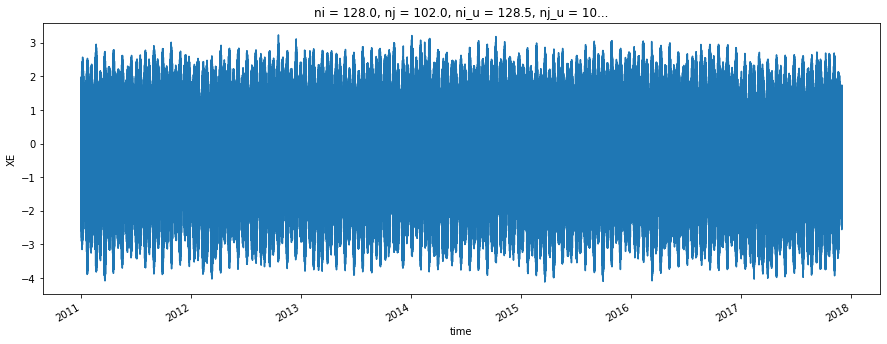

In [6]:
ds.XE.plot(figsize=(15,5))

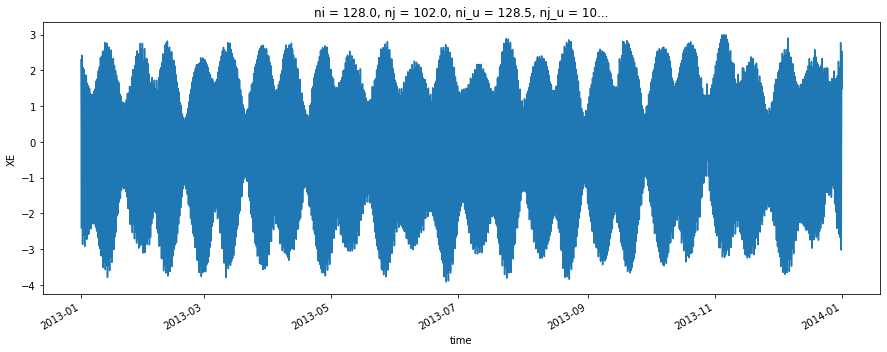

In [7]:
#for y in np.unique(ds.time.dt.year.data):
_ds = ds.where(ds.time.dt.year==2013, drop=True)
_ds.XE.plot(figsize=(15,5))

--- 
## tidal analysis

In [8]:
#def get_tidal_harmonics(time, eta):

wt = pytide.WaveTable() # not working on months like time series, need to restrict
# to restrict the constituents used
#wt = pytide.WaveTable(["M2", "S2", "N2", "K2", "K1", "O1", "P1", "Q1", "S1", "M4"]) 

time = ds.time.values.astype("datetime64[us]")
f, vu = wt.compute_nodal_modulations(time)

# perform the harmonic analysis
w = wt.harmonic_analysis(ds.XE.values, f, vu)

# put harmonic analysis results in dataset
dsh = xr.Dataset(dict(frequency=("constituent", wt.freq()*86400/2/np.pi),
                      frequency_rad=("constituent", wt.freq()), 
                      amplitude=("constituent", w),
                     ),
                 coords=dict(constituent=("constituent", wt.constituents()))
                )

# store for later use
if False:
    # netcdf does not not 
    dsh["amplitude_real"] = np.real(dsh["amplitude"])
    dsh["amplitude_imag"] = np.imag(dsh["amplitude"])
    dsh = dsh.drop_vars("amplitude")
    dsh.to_netcdf(os.path.join(ms.diag_dir,"station_tide.nc"), mode="w")

In [17]:
dsp = ut.predict_tides(ds.time, real=False, summed=False)
tidal_range = ut.compute_tidal_range(dsp.prediction)

Text(0.5, 1.0, 'Tidal harmonic amplitudes')

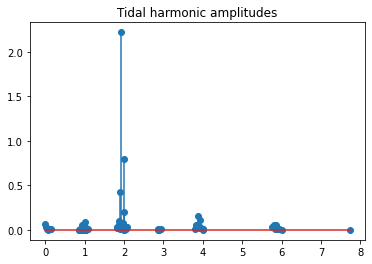

In [19]:
fig, ax = plt.subplots(1,1)
ax.stem(dsp.frequency, abs(dsp.amplitude))
ax.set_title("Tidal harmonic amplitudes")
#ax.xlim()

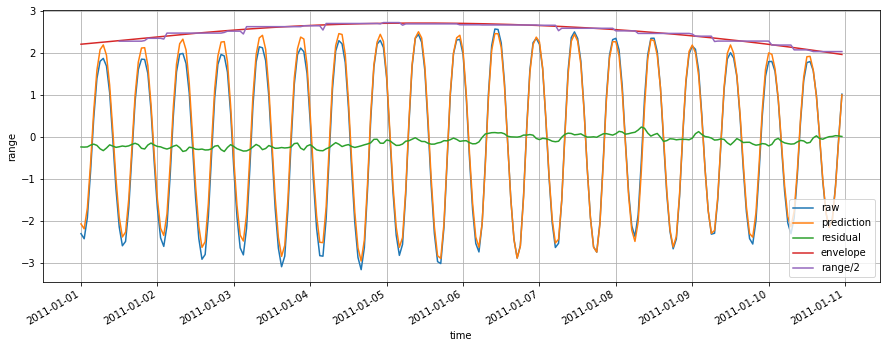

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

#t_slice = slice(0,24*20)
t_slice = slice(0,24*10)
_ds = ds.isel(time=t_slice)
_dsp = dsp.isel(time=t_slice)

_ds.XE.plot(ax=ax, label="raw")
_dsp.prediction.plot(ax=ax, label="prediction")
#_dsp.imag_summed.plot(ax=ax)
#envelope = abs(_ds.XE_harmonic+1j*_ds.XE_harmonic_quad)
#envelope.plot(ax=ax)

(_ds.XE - _dsp.prediction).plot(label="residual")

_dsp = _dsp.where( (_dsp.frequency>1.5) & (_dsp.frequency<2.5) )
#_ds = _ds.where( _ds.frequency>0.5 )
np.abs(_dsp["complex"].sum("constituent")).plot.line(label="envelope")

_trange = tidal_range.isel(time=t_slice)
(_trange/2).plot(ax=ax, label="range/2")

ax.grid()
ax.legend()


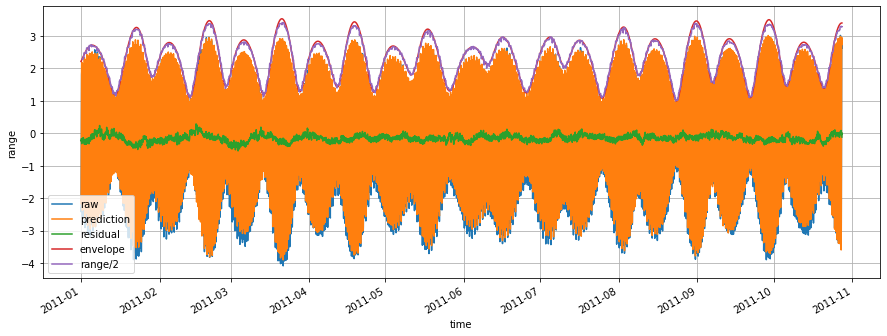

In [18]:

fig, ax = plt.subplots(1,1, figsize=(15,5))

t_slice = slice(0,24*300)
_ds = ds.isel(time=t_slice)
_dsp = dsp.isel(time=t_slice)

_ds.XE.plot(ax=ax, label="raw")
_dsp.prediction.plot(ax=ax, label="prediction")
#_dsp.imag_summed.plot(ax=ax)
#envelope = abs(_ds.XE_harmonic+1j*_ds.XE_harmonic_quad)
#envelope.plot(ax=ax)

(_ds.XE - _dsp.prediction).plot(label="residual")

_dsp = _dsp.where( (_dsp.frequency>1.5) & (_dsp.frequency<2.5) )
#_ds = _ds.where( _ds.frequency>0.5 )
np.abs(_dsp["complex"].sum("constituent")).plot.line(label="envelope")

_trange = tidal_range.isel(time=t_slice)
(_trange/2).plot(ax=ax, label="range/2")

ax.grid()
ax.legend()

---

In [ ]:
cluster.close()